<a href="https://colab.research.google.com/github/Moriblo/PUC_EngSoft_MVP4/blob/main/MVP_SPT4_EngSoft_FIMult_Vers%C3%A3o_Final_6.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Engenharia de Software - MVP Sprint 4
# Avaliação de Viabilidade de Investimento em Fundos Multimercado

## *   Definição do Problema <br>
Estabelecer uma forma simples de avaliação de viabilidade de um fundo de investimento, com um nível razoável de assertividade, considerando um número mínimo de variáveis. Entendendo como viabilidade, o retorno positivo em um período de carência de 30 (trinta) dias corridos.
## *   Coleta e Análise de Dados <br>
São utilizados dados diários dos fundos cadastrados na Comissão de Valores Mobiliários (CVM), para os seguintes atributos: Resgate do Dia [RESG_DIA], Captação no Dia [CAPTC_DIA], Número de Cotistas [NR_COTST] e Valor do Patrimônio Líquido [VL_PATRIM_LIQ].

--> Fonte: https://dados.cvm.gov.br/dataset/fi-doc-inf_diario

## *   Pré-processamento <br>
Foram consideradas as seguintes restrições no Pré-processamento: <br><br>
1 - Valor da Cota [VL_QUOTA] > 0 por entender que um fundo com valor de cota negativo, já é um fundo "esgotado" que não deve estar na base de análise. Além disso, há o cálculo do RETORNO, que será dado por VL_QUOTA do mês M+1 (df_2) menos VL_QUOTA no mês M (df_1), dia a dia.<br>
2 - Número de Cotistas [NR_COTST] > 1.000 por avaliar, durante análises dos dados dos datasets, que valores menores afetavam significativamente o comportamento de resgates e captações diárias.<br>
3 - Valor do Patrimônio Líquido [VL_PATRIM_LIQ] > 1.000.000 por avaliar, durante análises dos dados dos datasets, que valores menores afetavam significativamente o comportamento de resgates e captações diárias.<br>
4 - Classe do Fundo [CLASSE] = Fundo Multimercado, por ser um fundo de investimento de perfil intermediário, não tão conservador quanto um Fundo de Renda Fixa, nem tão arrojado quanto um Fundo de Ações. Todos os demais fundos constantes nos datasets (Fundo de Curto Prazo, Fundo Cambial, Fundo Referenciado, Fundo da Dívida Externa e FMP-FGTS), são fundos de classes muito específicas.<br><br>
ATRIBUTO ALVO:: RETORNO = VL_QUOTA (M+1) - VL_QUOTA (M). Se RETORNO > 0, SUGESTÃO = 1, investimento VIÁVEL, caso contrário SUGESTÃO = 0, INVIÁVEL. O atributo alvo será o campo [SUGESTÃO].
## *   Modelagem e Inferência <br>
Etapa que avalia e otimiza os modelos estudados.
## *   Pós-processamento <br>
Avaliou-se os dois modelos de maior performance, inclusive depois dos respectivos "tunings" (CART-norm e KNN-norm).
## *   Apresentação de Resultados <br>
Possibilita a entrada de valores quaisquer, seguindo as restrições definidas no pré-processamento, obtendo um retorno, do modelo, para o atributo alvo.
## *   Implantação do Modelo e Geração de Valor
Exporta para 'My Drive' no Google Drive,  um arquivo chamado "FIMulti_ModeloCART.pkl" com o modelo definido.




# COLETA E ANÁLISE DE DADOS

##_Requirements e Imports

In [2]:
!pip install scikit-learn
!pip install gdown
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.0 MB/s eta 0:00:00


In [3]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import ipywidgets as widgets

from google.colab import drive
from google.colab import files

from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest

from pickle import dump, load

from IPython.display import display, display_html, HTML
from scipy import stats


##_Carga dos Datasets

In [4]:
# Informa a URL de importação do dataset
id_arquivo_1 = '1R8vASJ_vSzykspidSdAVEXvnWIW8gIiG'
id_arquivo_2 = '1eFlNnCsX8HtRjAgPA2IsM-9nzKwG3FLD'
id_arquivo_cad = '1yO9-XahOdUOj00g9SyBBETASc84mRNtt'

# URLs para download direto dos arquivos
url_1 = f'https://drive.google.com/uc?id={id_arquivo_1}'
url_2 = f'https://drive.google.com/uc?id={id_arquivo_2}'
url_cad = f'https://drive.google.com/uc?id={id_arquivo_cad}'

# Faça o download dos arquivos
gdown.download(url_1, 'arquivo1.csv', quiet=False)
gdown.download(url_2, 'arquivo2.csv', quiet=False)
gdown.download(url_cad, 'arquivocad.csv', quiet=False)

# Lê o arquivo
df_1 = pd.read_csv('arquivo1.csv', delimiter=';')
df_2 = pd.read_csv('arquivo2.csv', delimiter=';')
df_cad = pd.read_csv('arquivocad.csv', delimiter=';')

# df_1 é o dataframe com os dados de performance diária do mês M
# df_2 é o dataframe com os dados de performance diária do mês M+1
# df_cad é o dataframe com os dados de cadastro dos Fundos de Investimento

Downloading...
From: https://drive.google.com/uc?id=1R8vASJ_vSzykspidSdAVEXvnWIW8gIiG
To: /content/arquivo1.csv
100%|██████████| 46.2M/46.2M [00:00<00:00, 51.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eFlNnCsX8HtRjAgPA2IsM-9nzKwG3FLD
To: /content/arquivo2.csv
100%|██████████| 49.0M/49.0M [00:00<00:00, 76.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yO9-XahOdUOj00g9SyBBETASc84mRNtt
To: /content/arquivocad.csv
100%|██████████| 3.59M/3.59M [00:00<00:00, 16.4MB/s]


##_Análise e Tratamento Inicial dos Datasets

In [5]:
# Criação de DataFrames temporários para armazenar os tipos de dados e contagens
temp1 = pd.DataFrame(df_1.dtypes, columns=['df_1_tipo'])
temp2 = pd.DataFrame(df_1.count(), columns=['df_1_count'])

temp3 = pd.DataFrame(df_2.dtypes, columns=['df_2_tipo'])
temp4 = pd.DataFrame(df_2.count(), columns=['df_2_count'])

temp5 = pd.DataFrame(df_cad.dtypes, columns=['df_cad_tipo'])
temp6 = pd.DataFrame(df_cad.count(), columns=['df_cad_count'])

# Concatenação dos DataFrames lado a lado
TypCol1 = pd.concat([temp1, temp2, temp3, temp4], axis=1)
TypCol2 = pd.concat([temp5, temp6], axis=1)

# Criando dicionário com os dados dos shapes
NumCol = {
 'df_1': df_1.shape,
 'df_2': df_2.shape,
 'df_cad': df_cad.shape
}

df_exib = pd.DataFrame(NumCol, index=['Número de linhas', 'Número de colunas'])
print(df_exib)
print()

# Exibição do tipo de dados nas colunas e consistência entre colunas
print(TypCol1)
print()
print(TypCol2)

# Serão utilizadas em df_1 e df_2, as colunas: CNPJ_FUNDO, DT_COMPTC, VL_QUOTA, VL_PATRIM_LIQ, CAPTC_DIA, RESG_DIA e NR_COTST.
# Serão utilizadas em df_cad, as colunas: CNPJ_FUNDO e CLASSE.

                     df_1    df_2  df_cad
Número de linhas   505556  537278   57126
Número de colunas       9       9       5

              df_1_tipo  df_1_count df_2_tipo  df_2_count
TP_FUNDO         object      505556    object      537278
CNPJ_FUNDO       object      505556    object      537278
DT_COMPTC        object      505556    object      537278
VL_TOTAL        float64      505556   float64      537278
VL_QUOTA         object      505556    object      537278
VL_PATRIM_LIQ   float64      505556   float64      537278
CAPTC_DIA       float64      505556   float64      537278
RESG_DIA        float64      505556   float64      537278
NR_COTST          int64      505556     int64      537278

              df_cad_tipo  df_cad_count
CNPJ_FUNDO         object         57126
DT_REG             object         57126
CLASSE             object         57126
DT_INI_CLASSE      object         57126
DT_FIM_CLASSE      object          5844


In [6]:
# Adequando VL_QUOTA à quantidade de casas decimais informada no "Dicionário de
# Dados" do dataset de origem (Dicionário.txt) e mudando o tipo de object para float
df_1['VL_QUOTA'] = df_1['VL_QUOTA'].astype(str).str.replace('.', '')
df_1['VL_QUOTA'] = df_1['VL_QUOTA'].astype(float)
df_1['VL_QUOTA'] = df_1['VL_QUOTA'] / (10**12)

df_2['VL_QUOTA'] = df_2['VL_QUOTA'].astype(str).str.replace('.', '')
df_2['VL_QUOTA'] = df_2['VL_QUOTA'].astype(float)
df_2['VL_QUOTA'] = df_2['VL_QUOTA'] / (10**12)

# PRÉ-PROCESSAMENTO

In [8]:
# "df_sr" dataframe Sem Restrições e "df_cr" dataframe Com Restrições (reinicializa os dataframes)
df_sr1 = df_cr1 = df_1
df_sr2 = df_cr2 = df_2

###___Restrições

#### ____Restrição 1 (VL_QUOTA>0)

In [9]:
# Aplicando a RESTRIÇÃO 1 estabelecendo VL_QUOTA positivo
df_cr1 = df_cr1[(df_cr1['VL_QUOTA'] > 0)]
df_cr2 = df_cr2[(df_cr2['VL_QUOTA'] > 0)]

# Comparando o número de linhas e colunas
data = {
    'df_sr1': df_sr1.shape,
    'df_cr1': df_cr1.shape,
    'df_sr2': df_sr2.shape,
    'df_cr2': df_cr2.shape
}

df_exib = pd.DataFrame(data, index=['Número de linhas', 'Número de colunas'])
print(df_exib)

                   df_sr1  df_cr1  df_sr2  df_cr2
Número de linhas   505556  503795  537278  535747
Número de colunas       9       9       9       9


#### ____Restrições 2 e 3 (Limites de NR_COTST e VL_PATRIM_LIQ)

In [10]:
# Aplicando a RESTRIÇÃO 2 estabelecendo o Limite Inferior para o Número de Cotistas
LimInf_NR_COTST = 1000
# Aplicando a RESTRIÇÃO 3 estabelecendo o Limite Inferior para o Valor do Patrimônio Líquido
LimInf_VL_PATRIM_LIQ = 1000000

df_cr1 = df_cr1[(df_cr1['NR_COTST'] >= LimInf_NR_COTST) & (df_cr1['VL_PATRIM_LIQ'] >= LimInf_VL_PATRIM_LIQ)]
df_cr2 = df_cr2[(df_cr2['NR_COTST'] >= LimInf_NR_COTST) & (df_cr2['VL_PATRIM_LIQ'] >= LimInf_VL_PATRIM_LIQ)]

# Comparando o número de linhas e colunas
data = {
    'df_sr1': df_sr1.shape,
    'df_cr1': df_cr1.shape,
    'df_sr2': df_sr2.shape,
    'df_cr2': df_cr2.shape
}

df_exib = pd.DataFrame(data, index=['Número de linhas', 'Número de colunas'])
print(df_exib)

                   df_sr1  df_cr1  df_sr2  df_cr2
Número de linhas   505556   29963  537278   31541
Número de colunas       9       9       9       9


#### ____Restrição 4 (Retringindo CLASSE)

In [11]:
# Aplicando a RESTRIÇÃO 4 estabelecendo a Classe do Fundo de Investimento como uma classe pré definida
Lim_Class = "Fundo Multimercado"

# Realizando o merge com a base de cadastro dos fundos, onde há a imformação da Classe do fundo df_cad['CLASSE']
df_cr1 = df_cr1.merge(df_cad[['CNPJ_FUNDO', 'CLASSE']], on='CNPJ_FUNDO', how='left')
df_cr1 = df_cr1[(df_cr1['CLASSE'] == Lim_Class)]
df_cr2 = df_cr2.merge(df_cad[['CNPJ_FUNDO', 'CLASSE']], on='CNPJ_FUNDO', how='left')
df_cr2 = df_cr2[(df_cr2['CLASSE'] == Lim_Class)]

# Comparando o número de linhas e colunas
data = {
    'df_sr1': df_sr1.shape,
    'df_cr1': df_cr1.shape,
    'df_sr2': df_sr2.shape,
    'df_cr2': df_cr2.shape
}

df_exib = pd.DataFrame(data, index=['Número de linhas', 'Número de colunas'])
print(df_exib)
print()

# Contar o número de linhas onde a coluna 'CLASSE' é diferente de vazio em df_cr1
countnoempity_df_cr1 = df_cr1[df_cr1['CLASSE'] != ''].shape[0]
countempity_df_cr1 = df_cr1[df_cr1['CLASSE'] == ''].shape[0]

# Contar o número de linhas onde a coluna 'CLASSE' é diferente de vazio em df_cr2
countnoempity_df_cr2 = df_cr2[df_cr2['CLASSE'] != ''].shape[0]
countempity_df_cr2 = df_cr2[df_cr2['CLASSE'] == ''].shape[0]

print(f"O número de linhas onde a coluna 'CLASSE' é diferente de vazio em df_cr1 é: {countnoempity_df_cr1}")
print(f"O número de linhas onde a coluna 'CLASSE' é vazio em df_cr1 é: {countempity_df_cr1}")
print()
print(f"O número de linhas onde a coluna 'CLASSE' é diferente de vazio em df_cr2 é: {countnoempity_df_cr2}")
print(f"O número de linhas onde a coluna 'CLASSE' é vazio em df_cr2 é: {countempity_df_cr2}")

                   df_sr1  df_cr1  df_sr2  df_cr2
Número de linhas   505556   12231  537278   12851
Número de colunas       9      10       9      10

O número de linhas onde a coluna 'CLASSE' é diferente de vazio em df_cr1 é: 12231
O número de linhas onde a coluna 'CLASSE' é vazio em df_cr1 é: 0

O número de linhas onde a coluna 'CLASSE' é diferente de vazio em df_cr2 é: 12851
O número de linhas onde a coluna 'CLASSE' é vazio em df_cr2 é: 0


###___Comparando os Dados (Com e Sem restrição)

                   df_sr1  df_cr1  df_sr2  df_cr2
Número de linhas   505556   12231  537278   12851
Número de colunas       9      10       9      10



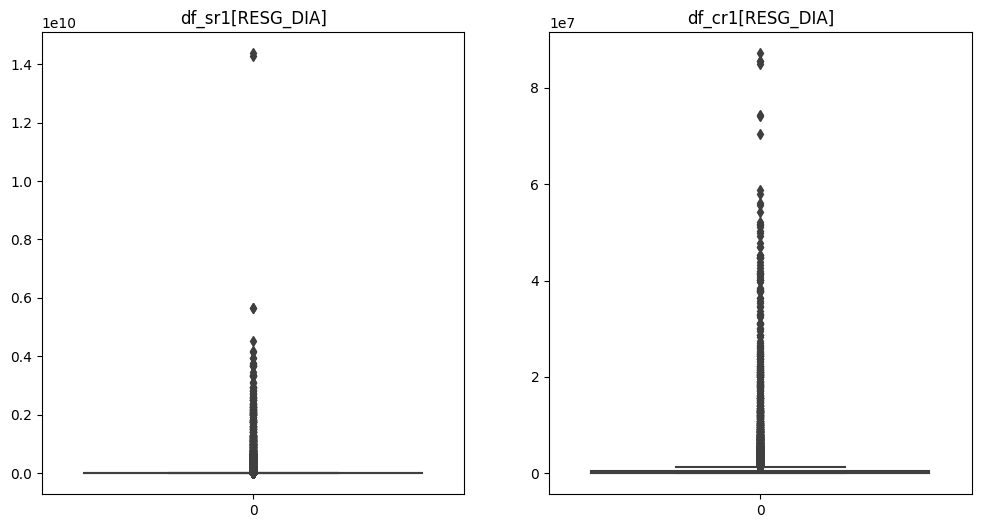

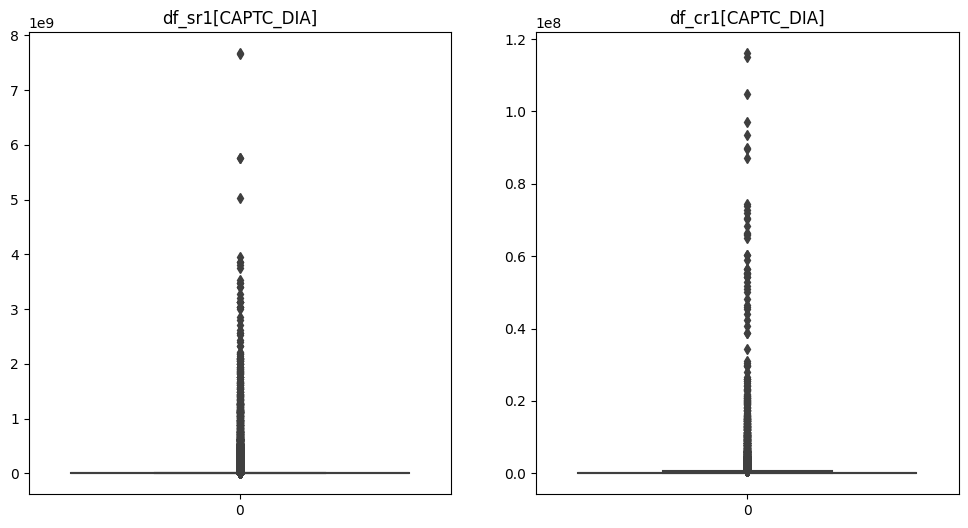

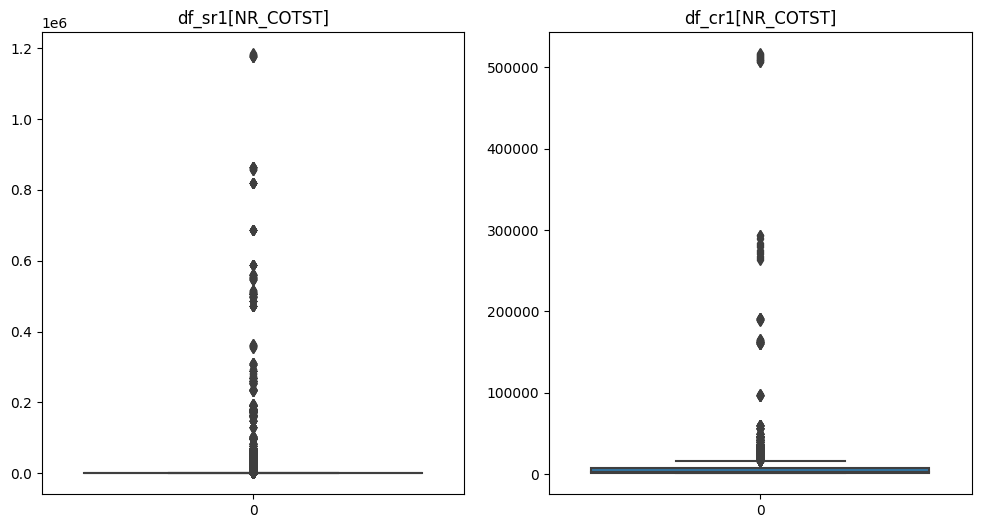

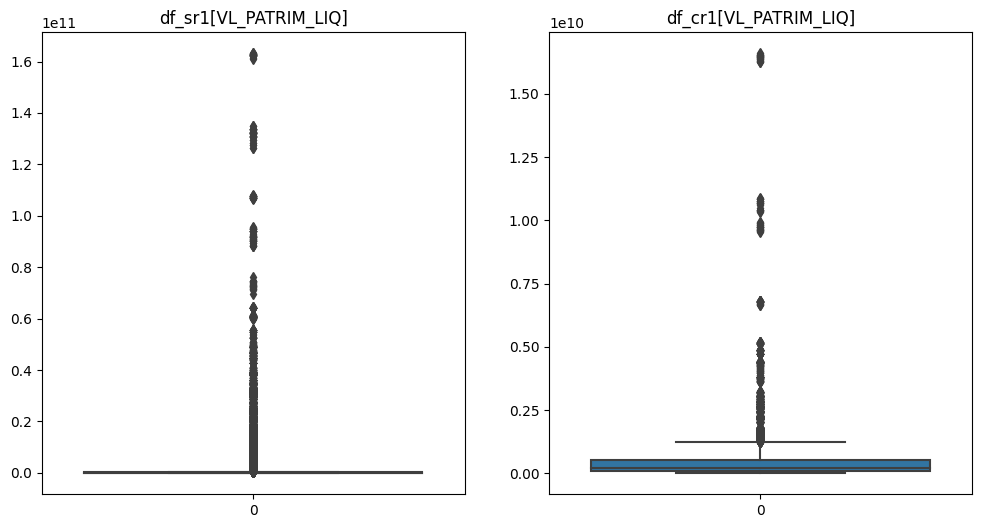

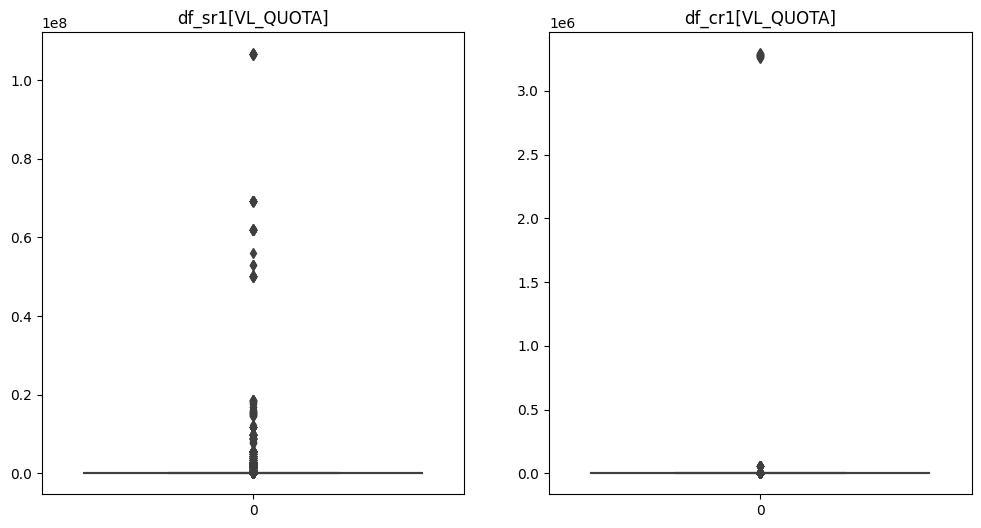

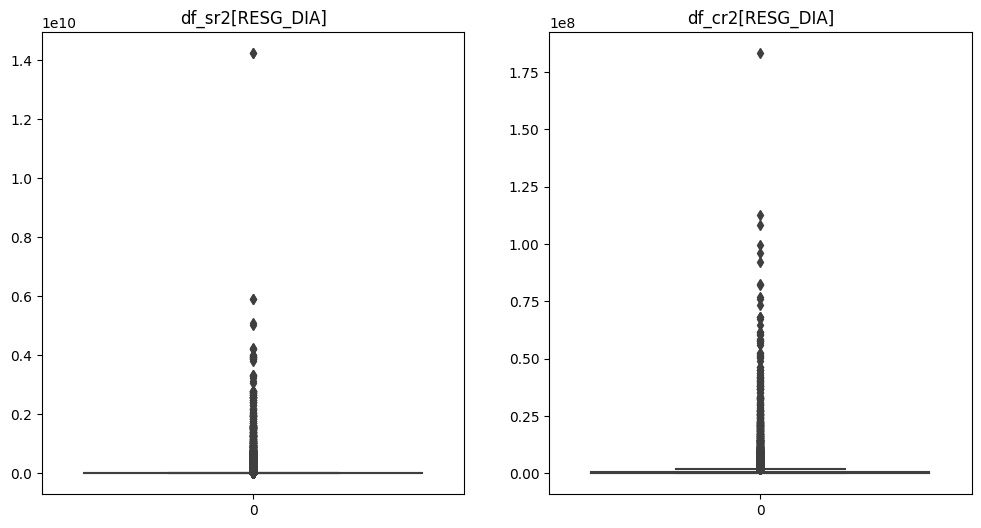

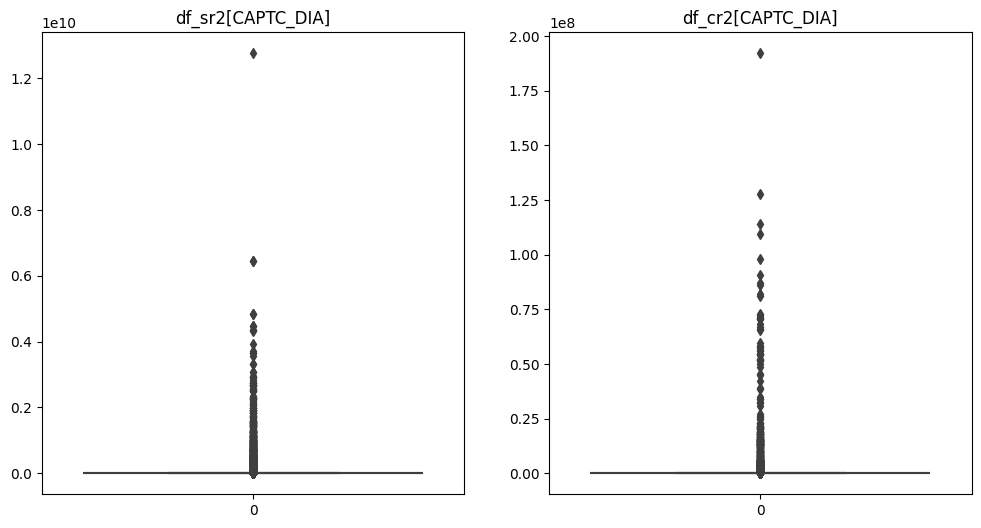

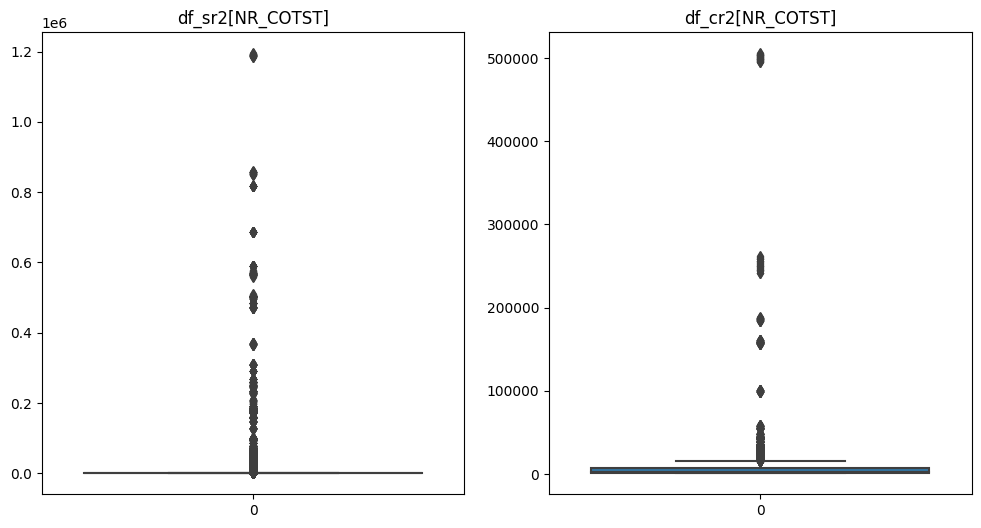

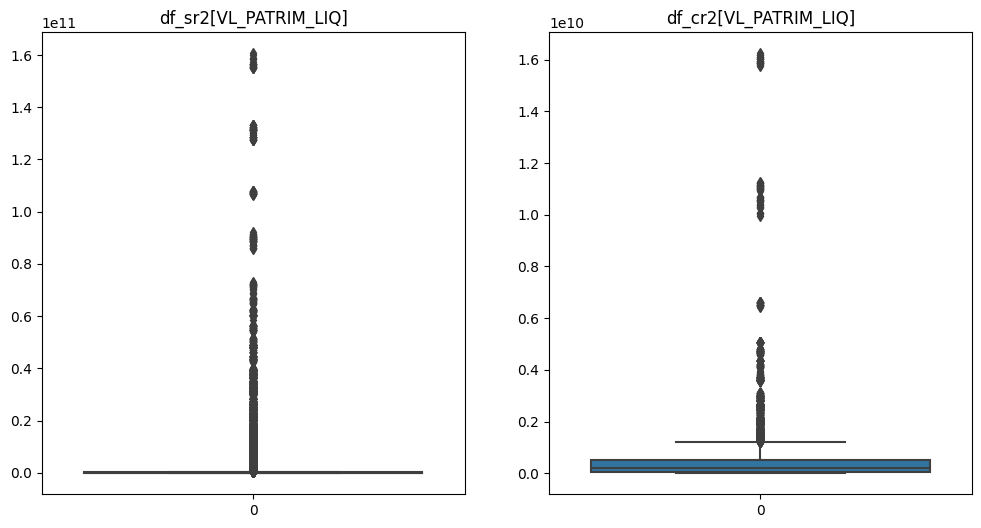

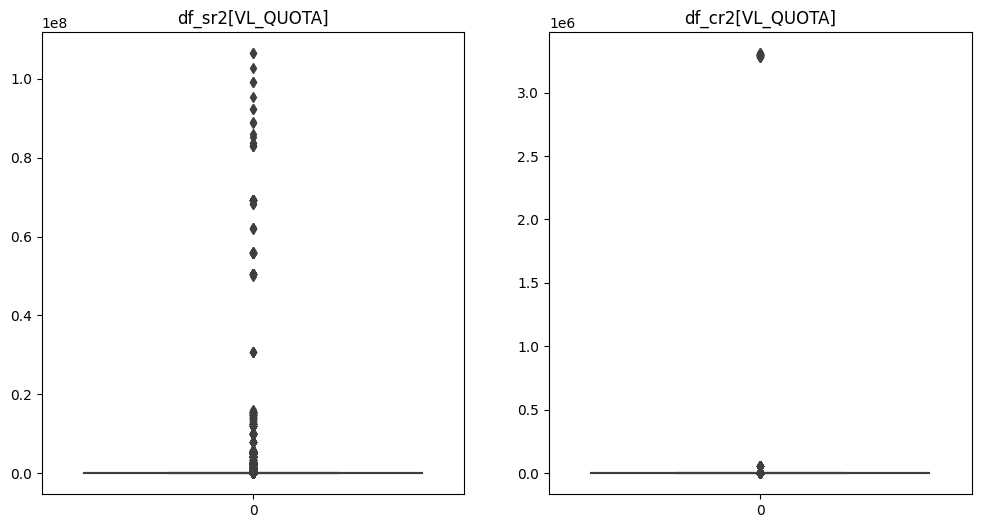

In [12]:
# Comparando o número de linhas e colunas
data = {
    'df_sr1': df_sr1.shape,
    'df_cr1': df_cr1.shape,
    'df_sr2': df_sr2.shape,
    'df_cr2': df_cr2.shape
}

df_exib = pd.DataFrame(data, index=['Número de linhas', 'Número de colunas'])

print(df_exib)
print()

# Definindo os dataframes e as colunas que se quer plotar
dataframes = [(df_sr1, df_cr1), (df_sr2, df_cr2)]
colunas = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', 'VL_QUOTA']

# Para cada par de dataframes
for i, (df1, df2) in enumerate(dataframes):

    # Para cada coluna
    for j, col in enumerate(colunas):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        sns.boxplot(ax=axs[0], data=df1[col].values)
        axs[0].set_title(f'df_sr{i+1}[{col}]')

        sns.boxplot(ax=axs[1], data=df2[col].values)
        axs[1].set_title(f'df_cr{i+1}[{col}]')

        plt.show()

###___Feature Selection and Engineering

In [13]:
# Considerando somente os dígitos referente ao "dia" em DT_COMPTC (Data de competência do documento)
df_cr1['DT_COMPTC_DIA'] = df_cr1['DT_COMPTC'].str.slice(0, 2)
df_cr2['DT_COMPTC_DIA'] = df_cr2['DT_COMPTC'].str.slice(0, 2)

# Definindo o index para o JOIN
df_cr1.set_index(['CNPJ_FUNDO', 'DT_COMPTC_DIA'], inplace=True)
df_cr2.set_index(['CNPJ_FUNDO', 'DT_COMPTC_DIA'], inplace=True)

# JOIN os dois DataFrames usando o índice e gera o Dataframe de Atributos (df_atrib)
df_atrib = df_cr1.join(df_cr2, rsuffix='_1')

# Reseta o índice
df_atrib.reset_index(inplace=True)

# Calculando os retornos "RET", dia a dia e arredondando em conformidade com as casa decimais definidas no Dicionário de Dados
df_atrib['RET_PATLIQ'] = (df_atrib['VL_PATRIM_LIQ_1'] - df_atrib['VL_PATRIM_LIQ']).round(2) # retorno sobre o Patrimônio Líquido
df_atrib['RET_QUOTA'] = (df_atrib['VL_QUOTA_1'] - df_atrib['VL_QUOTA']).round(12) # Retorno sobre o Valor da Quota
df_atrib['RET_NRCOTST'] = (df_atrib['NR_COTST_1'] - df_atrib['NR_COTST']).round(0) # Diferença do Número de Cotistas

# Mantém somente as colunas referentes ao mês M (df_cr1)
df_atrib = df_atrib.filter(regex='[^_1]$')

### DEFININDO O ATRIBUTO ALVO [SUGESTÃO] ###
# Se o patrimônio líquido for negativo, a SUGESTÃO é 0 (zero) "INVIÁVEL". Caso contrário, e considerando que o Número de Costistas seja
# positivo, SUGESTÃO é 1 (um) "VIÁVEL". A interpretação é que o Patrimônio Líquido está subindo mesmo com o Número de Cotistas também subindo.
# Importante destacar que o Valor da Quota (VL_QUOTA) já teve seu limite inferior estabelecido na RESTRIÇÃO 1.
df_atrib['SUGESTÃO'] = df_atrib.apply(lambda row: 0 if row['RET_PATLIQ'] < 0 else (1 if row['RET_QUOTA'] >=0 and row['RET_NRCOTST'] >=0 else 0), axis=1)

df_atrib = df_atrib.reset_index()

df_atrib['SUGESTÃO'] = df_atrib['SUGESTÃO'].astype(int)
atrib_alvo = "SUGESTÃO" # definição do Atributo Alvo

# Concluindo o Feature Selection and engineering
df_atrib = df_atrib[['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', \
                     'VL_QUOTA', 'SUGESTÃO']]

In [14]:
# Verificando se alguma coluna tem valores nulos ou vazios (missing parameters)
print((df_atrib.isnull() | (df_atrib == '')).any())
print()

# Supondo que 'df_atrib' é o seu DataFrame e 'coluna' é o nome da coluna
contagem = df_atrib['SUGESTÃO'].value_counts()
print(contagem)
print()

df_atrib

RESG_DIA         False
CAPTC_DIA        False
NR_COTST         False
VL_PATRIM_LIQ    False
VL_QUOTA         False
SUGESTÃO         False
dtype: bool

0    11512
1      829
Name: SUGESTÃO, dtype: int64



,RESG_DIA,CAPTC_DIA,NR_COTST,VL_PATRIM_LIQ,VL_QUOTA,SUGESTÃO
0,0.00,14450.00,1286,2.706302e+08,53323.244951,0
1,33725.63,0.00,1285,2.706602e+08,53333.819621,0
2,0.00,0.00,1285,2.708698e+08,53375.133049,0
3,0.00,52834.39,1286,2.707104e+08,53333.296389,0
4,0.00,19763.05,1287,2.709078e+08,53368.296319,0
...,...,...,...,...,...,...
12336,14528.14,67024.97,1290,1.347824e+06,1.000653,1
12337,0.00,57260.21,1382,1.404994e+06,1.000586,1
12338,0.00,24072.51,1447,1.430120e+06,1.001336,1
12339,5457.97,49572.45,1485,1.474783e+06,1.001720,0


### __Apresentação e Análise dos Atributos (antes da separação Treino/Teste)

*** Avaliação de df_atrib ***

              df_atrib_dtypes  df_atrib_count
RESG_DIA              float64           12341
CAPTC_DIA             float64           12341
NR_COTST                int64           12341
VL_PATRIM_LIQ         float64           12341
VL_QUOTA              float64           12341
SUGESTÃO                int64           12341

*** Avaliação do balanceamento de classes ***

Contagem de ocorrências em df_atrib:
 0    11512
1      829
Percentual de ocorrências em df_atrib:
 0    93.282554
1     6.717446
Name: SUGESTÃO, dtype: float64



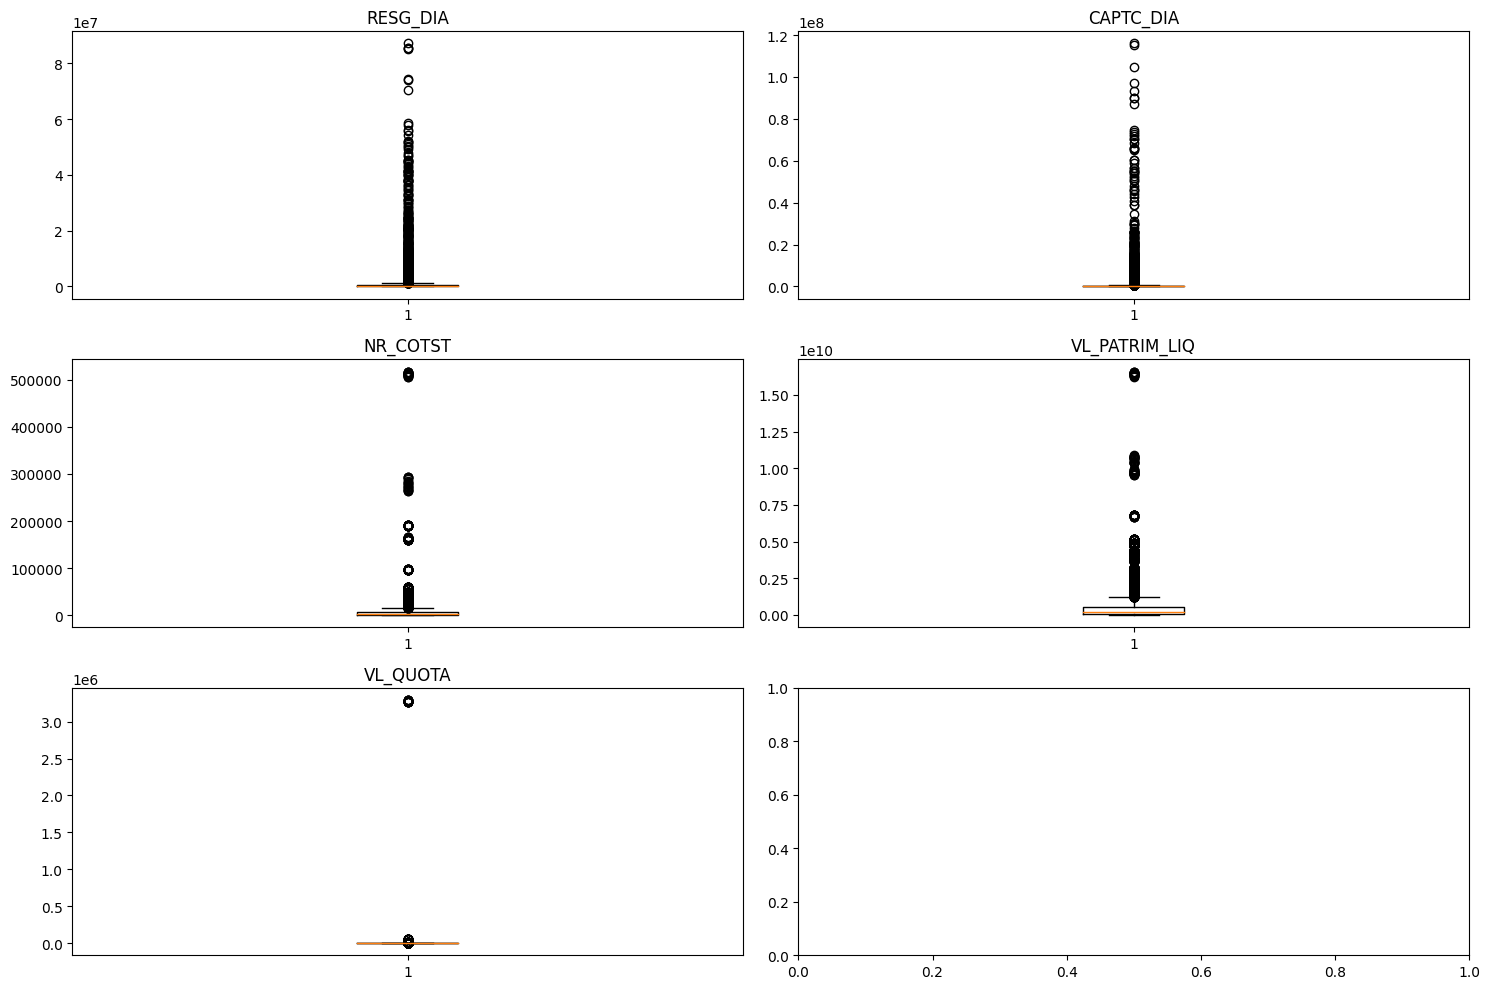

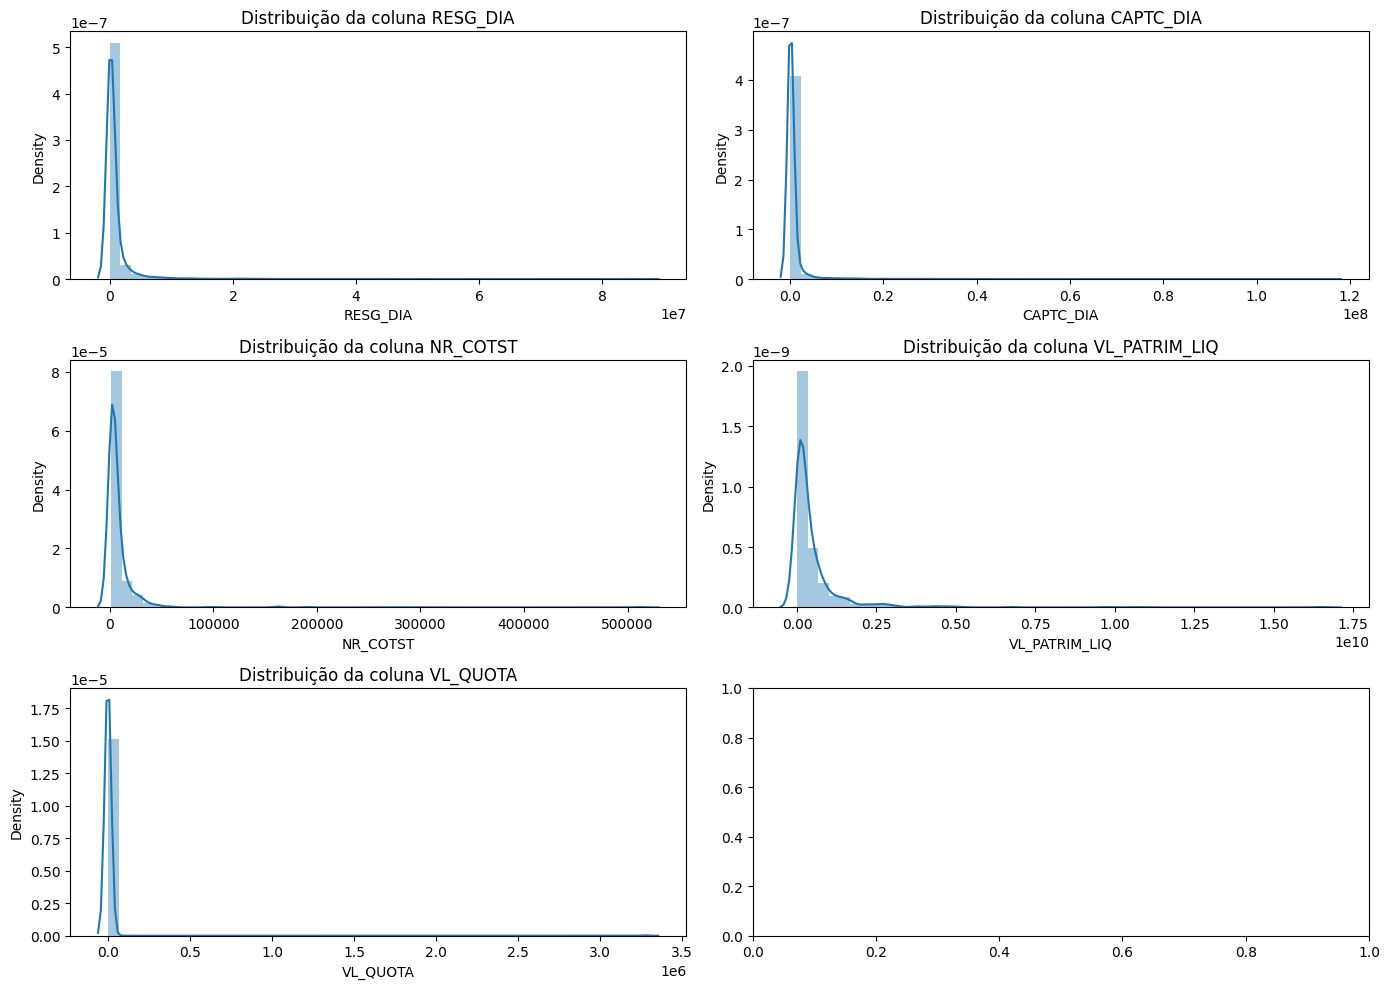

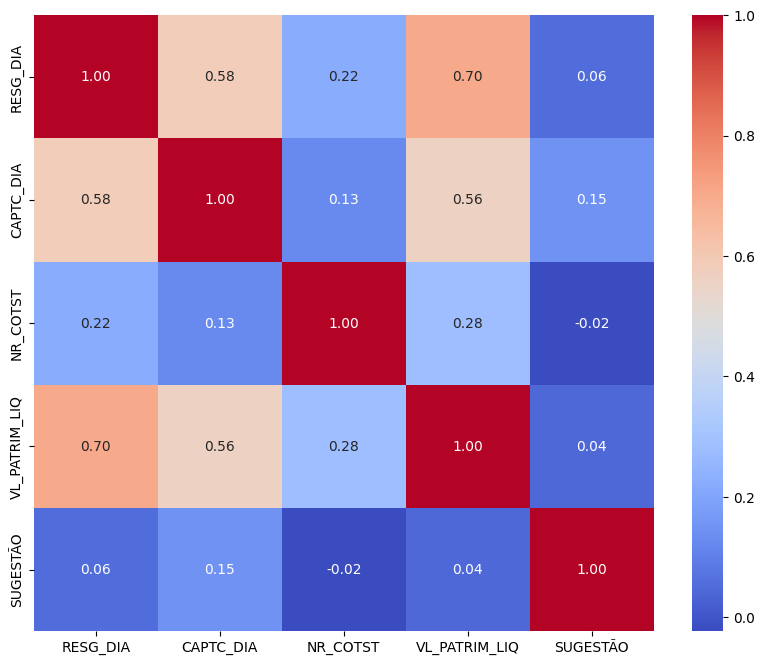

In [21]:
####### AVALIANDO OS DADOS #######

cols = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', \
                     'VL_PATRIM_LIQ', 'VL_QUOTA']

### DADOS TABELADOS ###

# Criação de DataFrames temporários para armazenar os tipos de dados e contagens
temp1 = pd.DataFrame(df_atrib.dtypes, columns=['df_atrib_dtypes'])
temp2 = pd.DataFrame(df_atrib.count(), columns=['df_atrib_count'])

# Criação de DataFrames temporários para armazenar as informações de shape
temp3 = pd.DataFrame([df_atrib.shape])

# Concatenação dos DataFrames lado a lado
result = pd.concat([temp1, temp2], axis=1)

# Comportamento de SUGESTÃO
counts = df_atrib['SUGESTÃO'].value_counts()

# Exibição do resultado
print("*** Avaliação de df_atrib ***")
print()
print(result)
print()

print("*** Avaliação do balanceamento de classes ***")
print()
# Contagem de ocorrências em df_atrib
contagem_atrib = counts.to_string(dtype=False)
print("Contagem de ocorrências em df_atrib:\n", contagem_atrib)
percent_atrib = df_atrib['SUGESTÃO'].value_counts(normalize=True) * 100
print("Percentual de ocorrências em df_atrib:\n", percent_atrib)
print()

### BOXPLOT ###

df_box = df_atrib.drop(atrib_alvo, axis=1)

fig, axs = plt.subplots(3, 2, figsize=(15, 10))

for i, col in enumerate(cols):
    ax = axs[i//2, i%2]  # Determina a posição do subplot
    ax.boxplot(df_box[col])
    ax.set_title(col)

plt.tight_layout()
plt.show()

### DISTRIBUIÇÃO LINEAR ###

# Cria uma figura com 2 linhas e 2 colunas de subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

# Para cada coluna, cria um gráfico de distribuição linear
for i, col in enumerate(cols):
    sns.distplot(df_atrib[col], ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title('Distribuição da coluna {}'.format(col))

plt.tight_layout()
plt.show()

### MAPA DE CALOR DE CORRELAÇÃO ###

# Seleciona as colunas de interesse
cols = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', 'SUGESTÃO']

# Calcula a matriz de correlação
corr = df_atrib[cols].corr()

# Cria um mapa de calor com a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=corr.columns, yticklabels=corr.columns)

plt.show()

###___Separação em conjunto de treino e conjunto de teste com holdout

In [22]:
np.random.seed(7) # definindo uma semente global para este bloco

####### DEFININDO PARÂMETROS DO CONJUNTO DE TREINO e TESTE #######

test_size = 0.30 # tamanho do conjunto de teste (Testes foram realizados entre .10 e .30, tendo .30 como melhor resultado de representatividade entre a
# base original e as bases X_train e X_test).
seed = 7 # semente aleatória
num_particoes = 10 # número de partições para validação cruzada
atrib_alvo = "SUGESTÃO" # informando a coluna do atributo alvo

# Separando os atributos
y = df_atrib[atrib_alvo] # Atributo alvo em y
X = df_atrib.drop(atrib_alvo, axis=1) # Demais atributos em x

# Fazer a separação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y)

# Parâmetros e partições da validação cruzada
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação


###___Comparação: Original, X_treino, X_test

*** Avaliação do balanceamento de classes ***

Percentual de ocorrências em df_atrib:
 0    93.282554
1     6.717446
Name: SUGESTÃO, dtype: float64


Percentual de ocorrências em y_train:
 0    93.285483
1     6.714517
Name: SUGESTÃO, dtype: float64


Percentual de ocorrências em y_test:
 0    93.275722
1     6.724278
Name: SUGESTÃO, dtype: float64

*** BOXPLOT ***



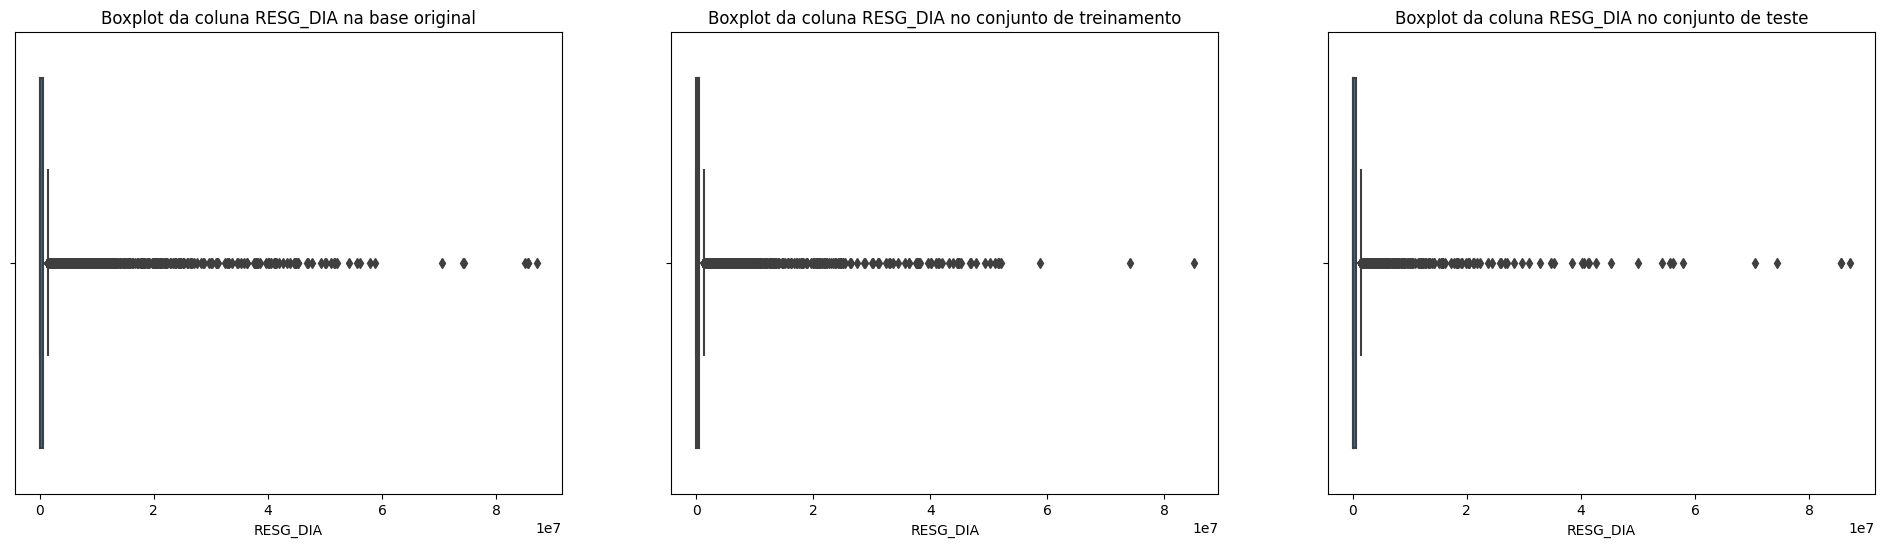

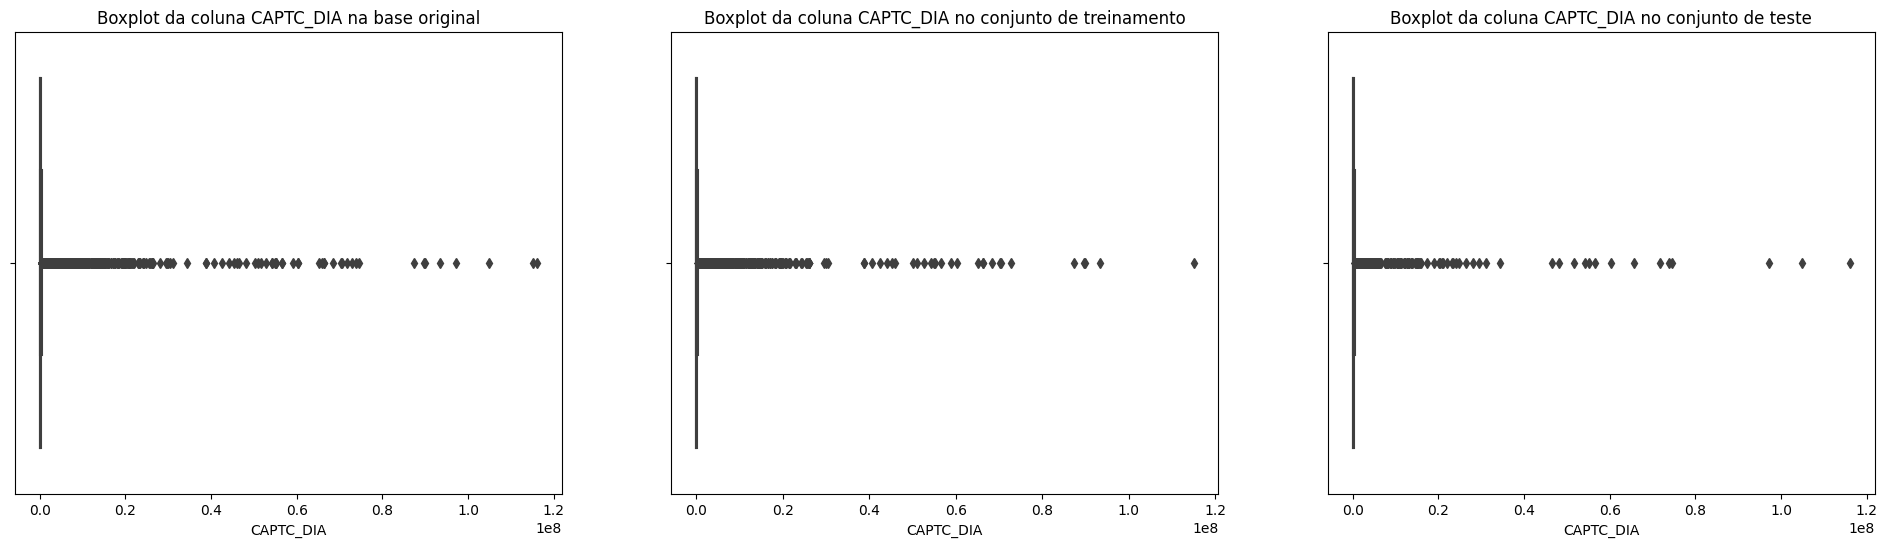

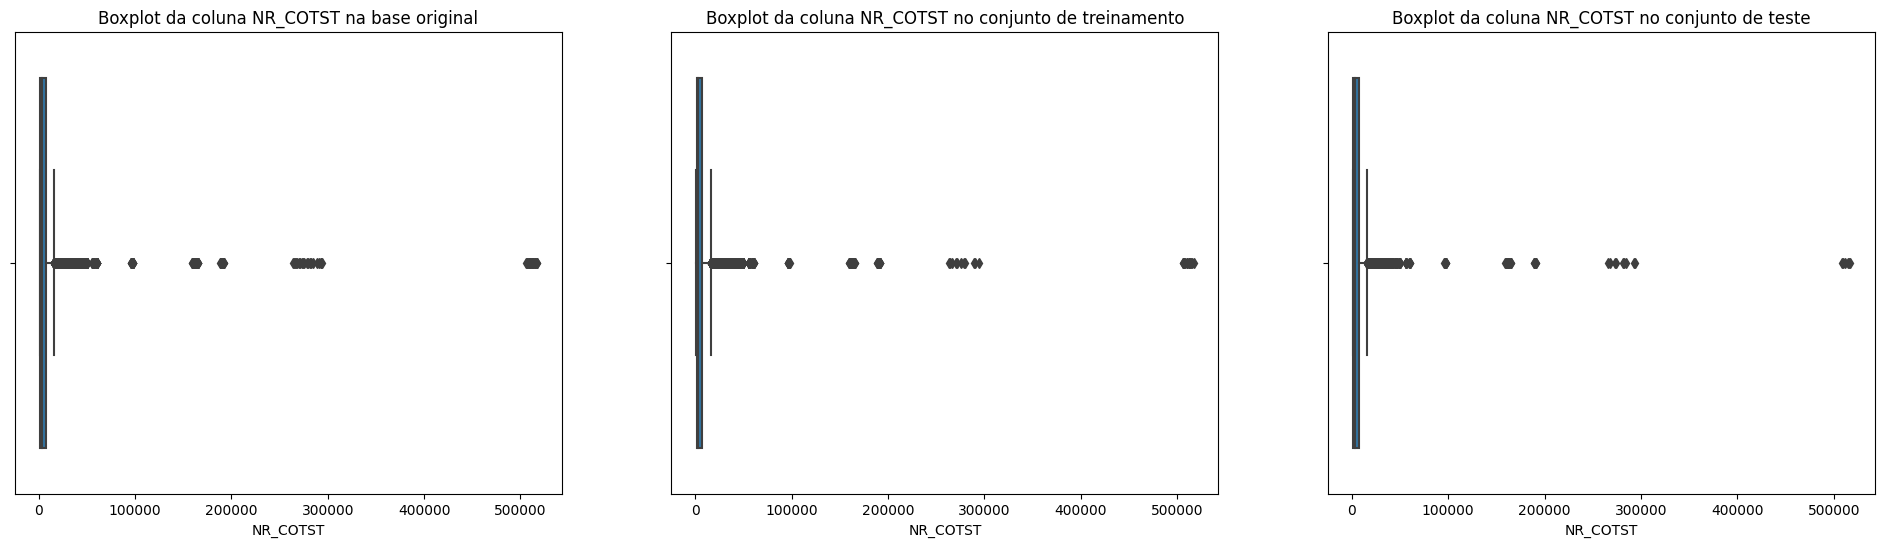

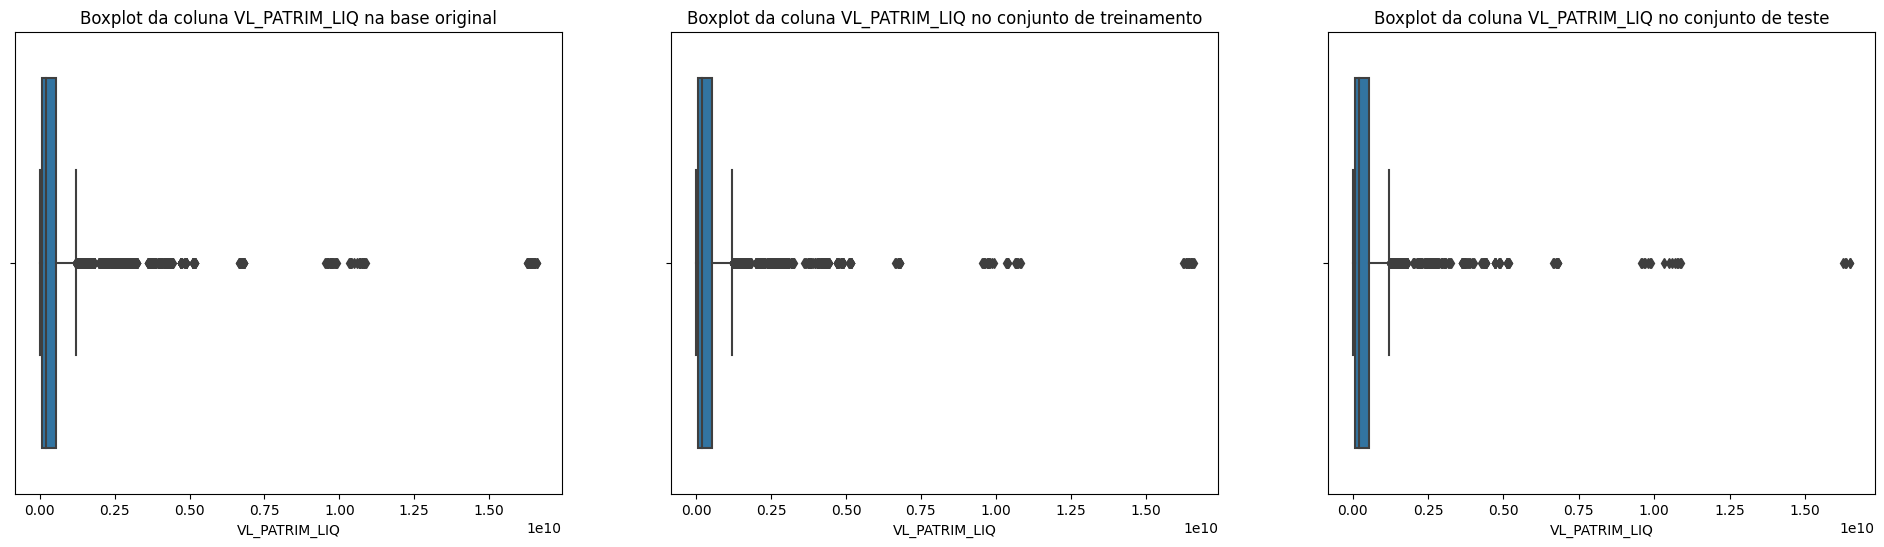

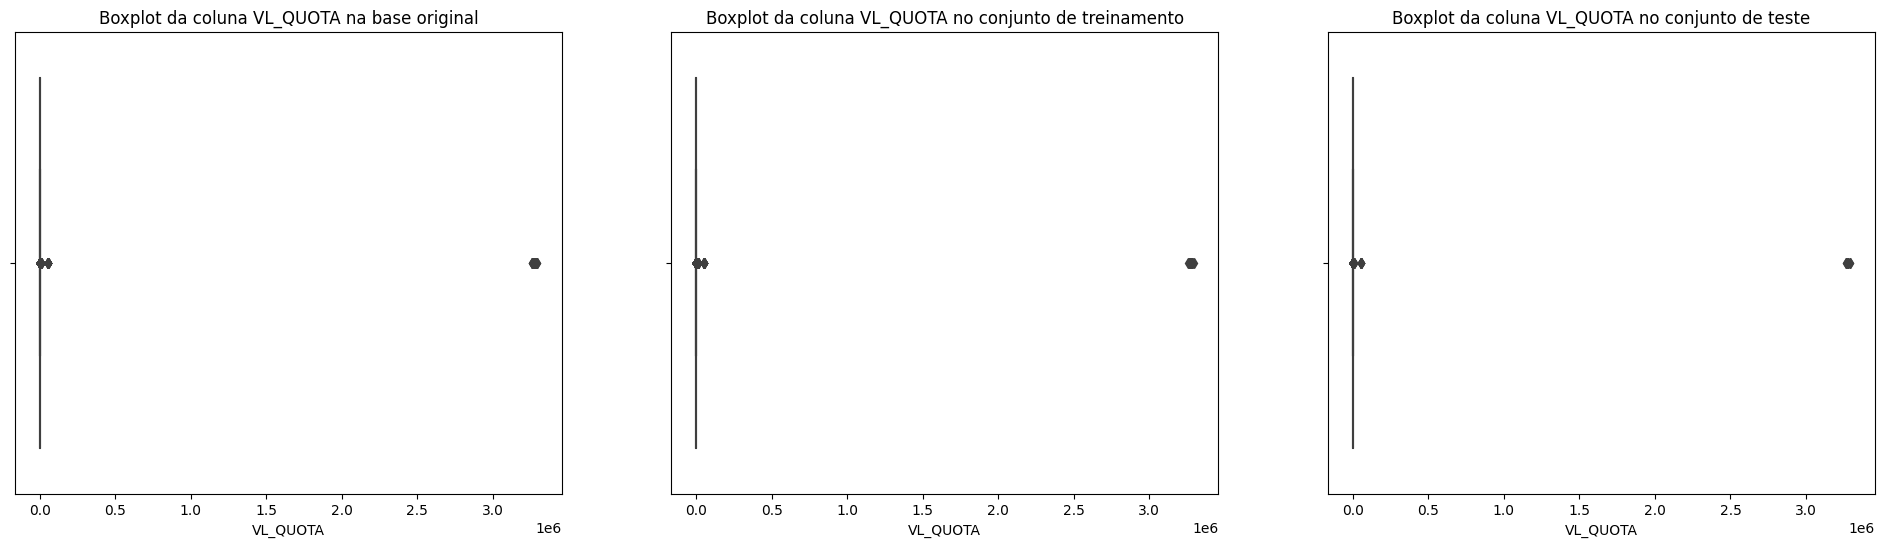


*** MAPA DE CALOR de Correlação ***



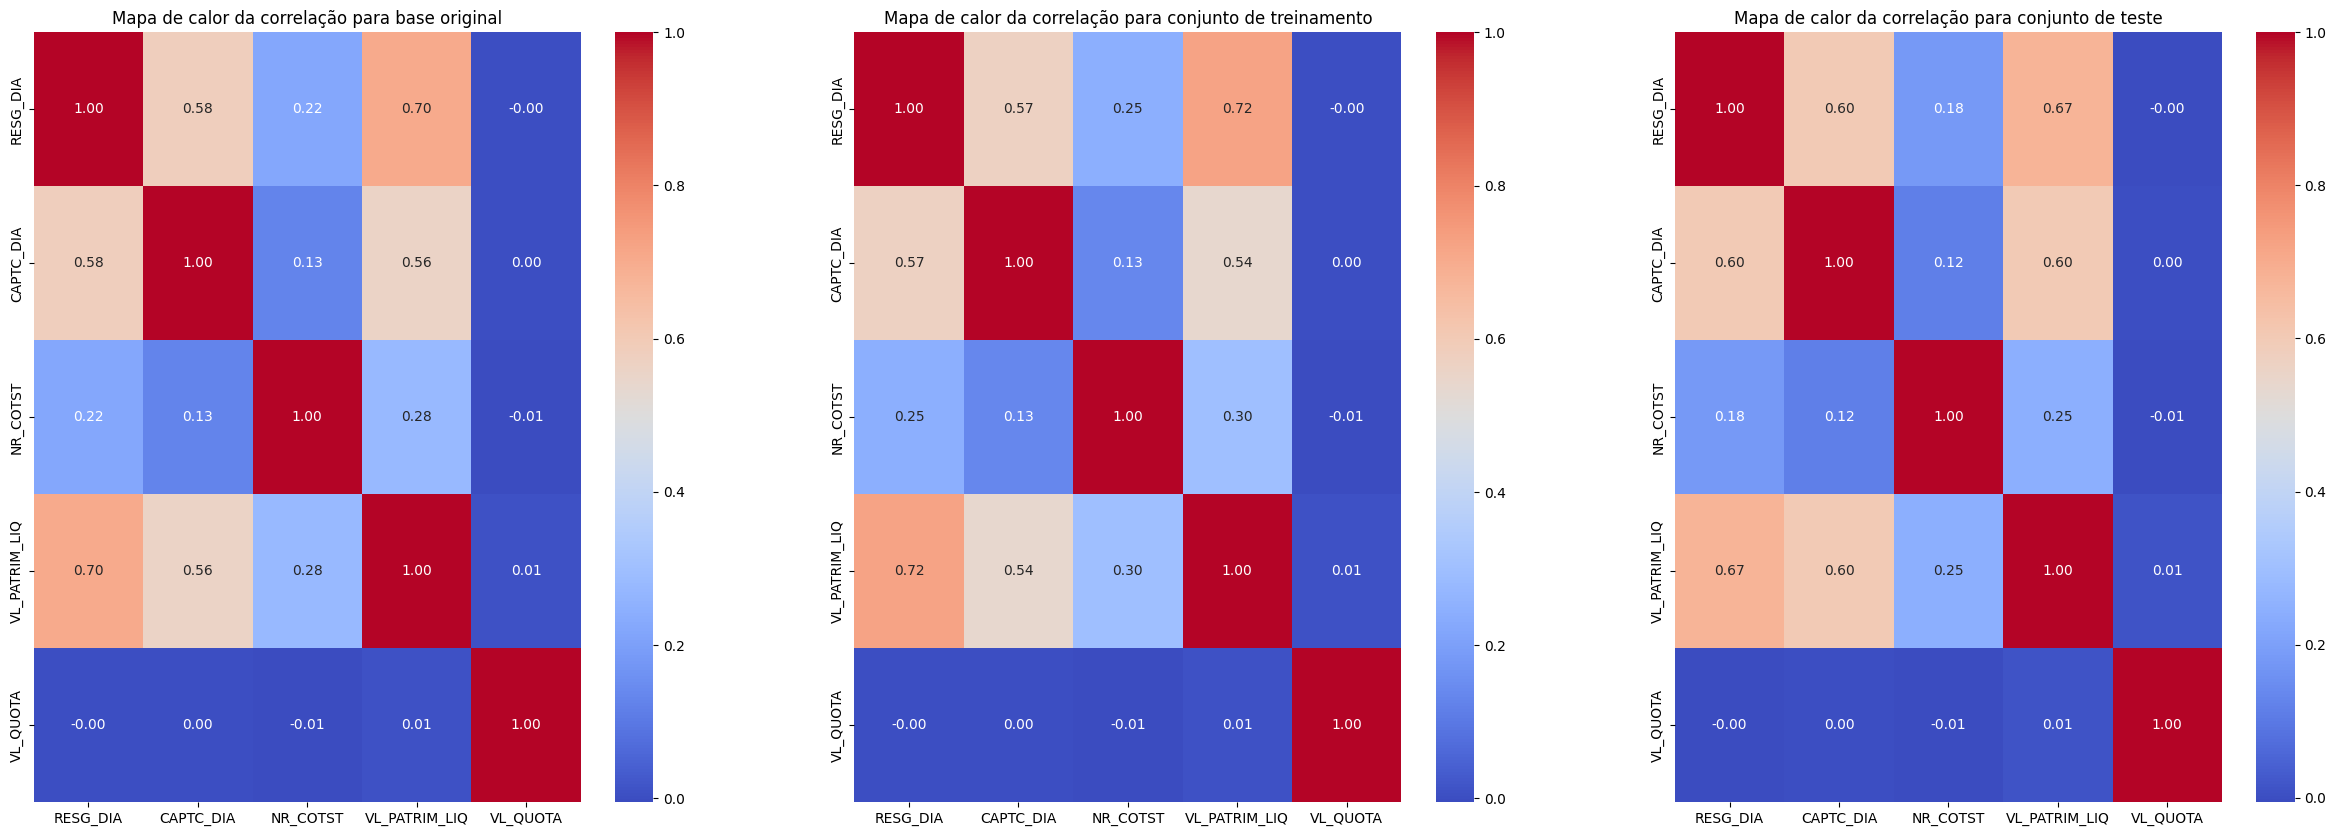

In [26]:
print("*** Avaliação do balanceamento de classes ***")
print()

# Contagem de ocorrências em df_atrib
contagem_atrib = df_atrib['SUGESTÃO'].value_counts(normalize=True) * 100
print("Percentual de ocorrências em df_atrib:\n", contagem_atrib)
print()

# Contagem de ocorrências em y_train
contagem_y_train = y_train.value_counts(normalize=True) * 100
print("\nPercentual de ocorrências em y_train:\n", contagem_y_train)
print()

# Contagem de ocorrências em y_test
contagem_y_test = y_test.value_counts(normalize=True) * 100
print("\nPercentual de ocorrências em y_test:\n", contagem_y_test)
print()

### BOXPLOT PARA COMPARAÇÃO DOS DADOS DE TREINO E TESTE ###
print("*** BOXPLOT ***")
print()
# Obtém as colunas do dataframe de treinamento (o número de colunas é o mesmo para o dataframe de teste)
colunas = X_train.columns

# Cria um boxplot para cada coluna nos conjuntos de treinamento e teste
df_atrib_saa = df_atrib.drop(atrib_alvo, axis=1) # todos os demais atributos sem o atributo alvo (sem SUGESTÃO)
for col in colunas:
    fig, axs = plt.subplots(1, 3, figsize=(24, 6))  # cria uma figura com 3 subplots (lado a lado)

    # Boxplot da coluna no conjunto de treinamento
    sns.boxplot(x=df_atrib_saa[col], ax=axs[0])
    axs[0].set_title('Boxplot da coluna ' + col + ' na base original')

    # Boxplot da coluna no conjunto de treinamento
    sns.boxplot(x=X_train[col], ax=axs[1])
    axs[1].set_title('Boxplot da coluna ' + col + ' no conjunto de treinamento')

    # Boxplot da coluna no conjunto de teste
    sns.boxplot(x=X_test[col], ax=axs[2])
    axs[2].set_title('Boxplot da coluna ' + col + ' no conjunto de teste')

    plt.show()

print()

### MAPA DE CALOR DE CORRELÇÃO ###
print("*** MAPA DE CALOR de Correlação ***")
print()

# Lista de dataframes para análise
dfs = [df_atrib_saa, X_train, X_test]
df_names = ['base original', 'conjunto de treinamento', 'conjunto de teste']

# Cria uma figura com 3 subplots (lado a lado)
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# Loop através de cada dataframe
for i in range(len(dfs)):
    # Calcula a matriz de correlação
    corr = dfs[i].corr()

    # Cria um mapa de calor com a matriz de correlação
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=corr.columns, yticklabels=corr.columns, ax=axs[i])
    axs[i].set_title('Mapa de calor da correlação para ' + df_names[i])

plt.show()


# MODELAGEM E INFERÊNCIA

## _Criação e avaliação de modelos: linha base

CART: 0.426850 (0.047806)
KNN: 0.402128 (0.062296)
SVM: 0.400000 (0.351188)
NB: 0.154922 (0.100703)


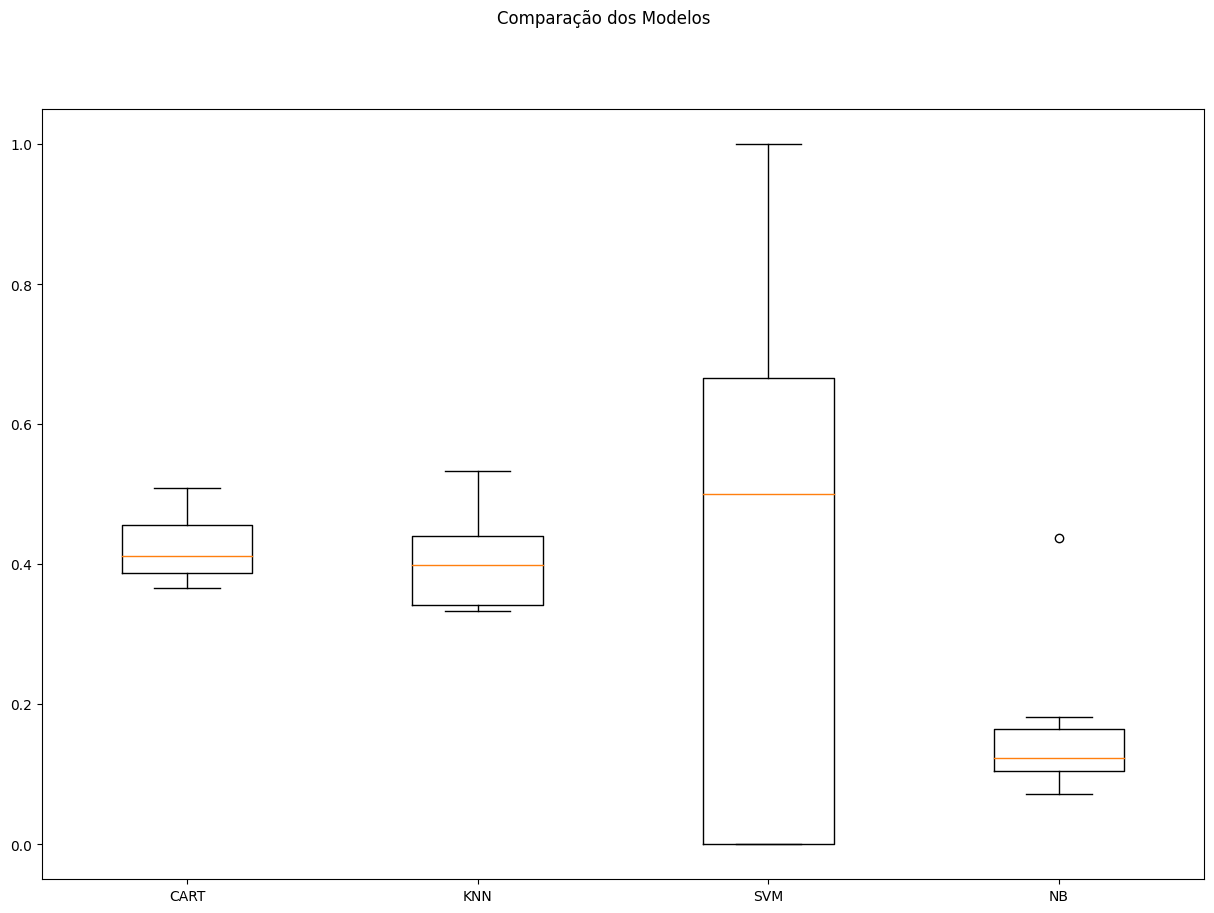

In [ ]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []
# scoring = 'accuracy' # métrica de avaliação para o desempenho do modelo
scoring = 'precision' # métrica de avaliação para o desempenho do modelo

# Avaliação dos modelos
results = []
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    # Armazenando os resultados em uma lista de tuplas
    results.append((name, cv_results))

# Ordenando os resultados em ordem decrescente
results.sort(key=lambda x: x[1].mean(), reverse=True)

# Imprimindo os resultados ordenados
for name, cv_results in results:
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot([x[1] for x in results])  # usando os resultados ordenados para o boxplot
ax.set_xticklabels([x[0] for x in results])  # usando os nomes dos modelos ordenados para o boxplot
plt.show()


## _Criação e avaliação de modelos: dados padronizados e normalizados

KNN-padr: 0.486 (0.100)
KNN-norm: 0.480 (0.129)
SVM-padr: 0.433 (0.416)
CART-orig: 0.430 (0.052)
CART-padr: 0.412 (0.048)
CART-norm: 0.409 (0.038)
KNN-orig: 0.402 (0.062)
SVM-orig: 0.400 (0.351)
SVM-norm: 0.333 (0.387)
NB-padr: 0.195 (0.173)
NB-norm: 0.195 (0.173)
NB-orig: 0.155 (0.101)

O melhor modelo é: KNN-padr


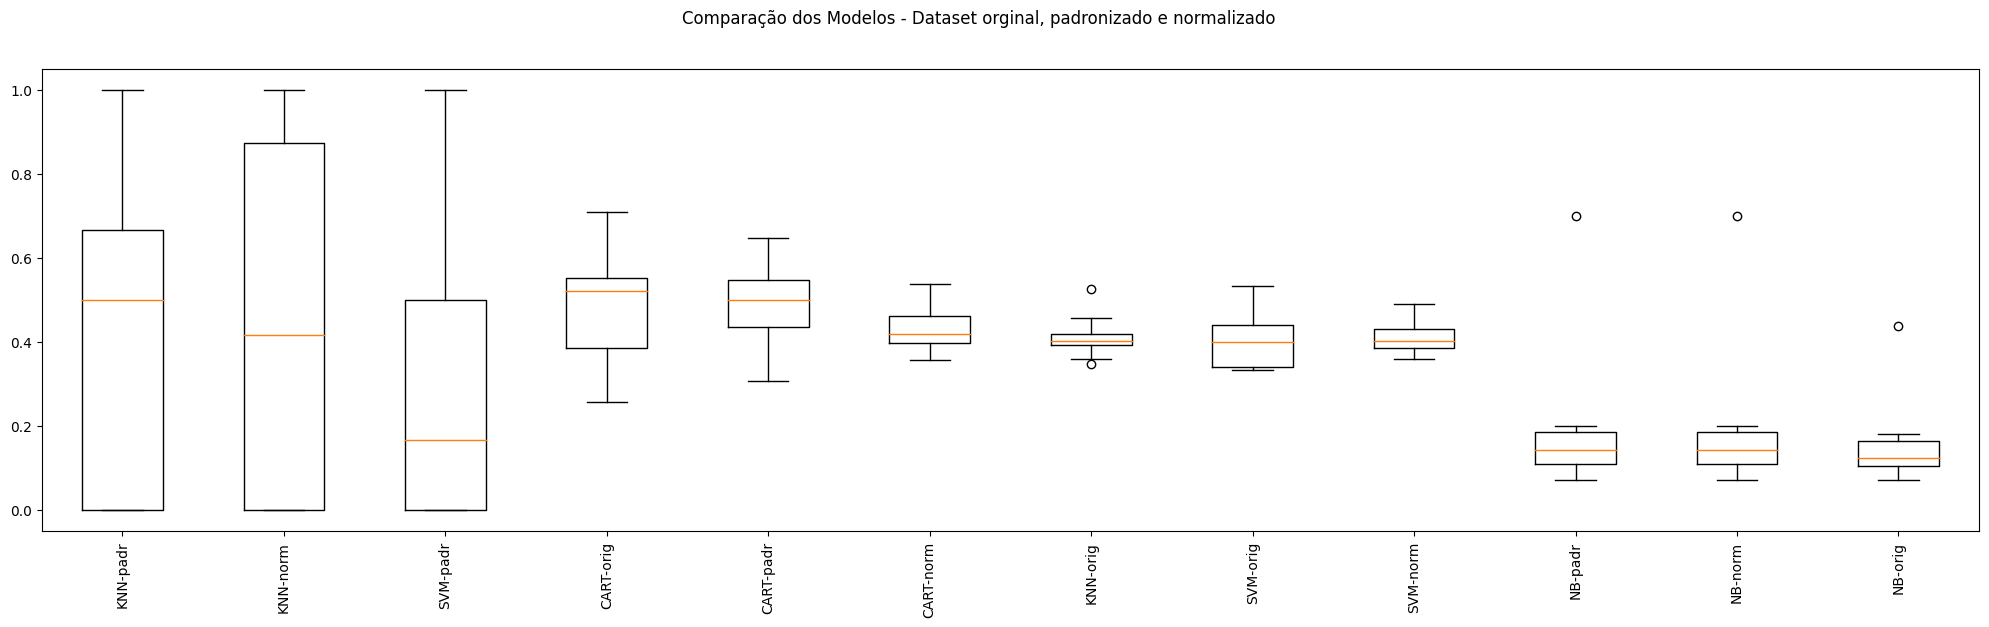

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
names = []
results = []
numeric_results = []
results_final = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))

# Dataset Padronizado
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))

# Dataset Normalizado
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    # Armazenando os resultados em uma lista de tuplas
    results.append((name, cv_results.mean(), cv_results.std()))
    numeric_results.append(cv_results)  # Armazenando os resultados numéricos

# Ordenando os resultados em ordem decrescente
results = sorted(results, key=lambda x: x[1], reverse=True)
numeric_results = sorted(numeric_results, key=lambda x: x[1].mean(), reverse=True)

# Imprimindo os resultados ordenados
for name, mean, std in results:
    msg = "%s: %.3f (%.3f)" % (name, mean, std) # formatando para 3 casas decimais
    print(msg)

# Imprimindo o modelo de melhor performance em relação à acurácia
results_final = results
print()
print("O melhor modelo é:", results_final[0][0])

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(numeric_results)  # Usando os resultados numéricos para o boxplot
ax.set_xticklabels([x[0] for x in results], rotation=90)  # usando os nomes dos modelos ordenados para o boxplot
plt.show()


## _Otimização dos hiperparâmetros

A tentativa de tuning, tanto por gridsearch quanto por randomizedsearch, ficaram extremamente demoradas e por isso optou-se por utilizar os valores default para SVM (kernel='linear', C=1.0, gamma='scale').

KNN

In [ ]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.613167 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 21}
Sem tratamento de missings: knn-padr - Melhor: 0.651154 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 19}
Sem tratamento de missings: knn-norm - Melhor: 0.674245 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 19}


In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = MinMaxScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='manhattan', n_neighbors=19)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.9305780659103188


In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=19)

###___Finalizando Modelo (SVM)

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino

model = SVC(kernel='linear', C=1.0, gamma='scale') # ajuste do modelo de acordo com a melhor combinação conseguida
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.9327390599675851


In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset

# Ajustando o modelo
model.fit(rescaledX, y)

model_svm = model

# Imprimindo todos os parâmetros do modelo
print("Parâmetros do modelo:")
print(model_svm.get_params())


Parâmetros do modelo:
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


###___Simulação

In [ ]:
########## ENTRADA DOS DADOS PARA SIMULAÇÃO #######

# Número de vetores
n = 15

# Dados dos vetores
RESG_DIA_VEC = [46802.05, 3343.61, 1384.09, 11168.33, 32623.78, 10289.67, 13690.82, 41044.33, 1140.43, \
                76571.88, 24804.62, 1994.87, 11647.36, 7000.00, 28930.60]

CAPTC_DIA_VEC = [11350.65, 106456.04, 129294.14, 73600.41, 212574.54, 267612.39, 83614.43, 66667.49, 34138.50, \
                 98332.57, 230980.98, 386598.17, 487016.16, 162196.93, 114539.80]

NR_COTST_VEC = [1126, 1132, 1136, 1137, 1143, 1157, 1165, 1179, 1185, 1189, 1197, 1215, 1234, 1249, 1269]

VL_PATRIM_LIQ_VEC = [73525062.76, 73618226.10, 73709661.09, 73745622.27, 74040673.26, 74231139.51, 74389697.08, \
                     74443638.15, 74471284.98, 74479675.36, 74744780.43, 75211019.11, 75690494.12, 75838493.54, 76023808.07]

VL_QUOTA_VEC = [19.801721324000, 19.799041845000, 19.789232164000, 19.782125377000, 19.813000795000, 19.795110258000, 19.818746144000, \
                19.826290540000, 19.824865364000, 19.821306072000, 19.836988791000, 19.858654518000, 19.859738718000, 19.857850229000, 19.883957465000]

SUGESTÃO_VEC = [1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]

SUGESTÃO_SIMULA_VEC = []



####################################################

# Lista para armazenar os vetores
vetores = []

for i in range(n):
  RESG_DIA = RESG_DIA_VEC[i]
  CAPTC_DIA = CAPTC_DIA_VEC[i]
  NR_COTST = NR_COTST_VEC[i]
  VL_PATRIM_LIQ = VL_PATRIM_LIQ_VEC[i]
  VL_QUOTA = VL_QUOTA_VEC[i]
  if RESG_DIA is None or CAPTC_DIA is None or NR_COTST is None or VL_PATRIM_LIQ is None or VL_QUOTA is None:
    print("Erro: Não pode haver campo vazio.")
  # Adicionar o vetor à lista de vetores
  vetores.append([RESG_DIA, CAPTC_DIA, NR_COTST, VL_PATRIM_LIQ, VL_QUOTA_VEC])

  # Converter a lista de vetores em um DataFrame
  data = pd.DataFrame(vetores, columns=['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', VL_QUOTA])

  # Verificando as restrições
  if RESG_DIA < 0 or CAPTC_DIA < 0:
      print("Erro: RESG_DIA e CAPTC_DIA devem ser maiores ou iguais a zero.")
  elif NR_COTST < 1000:
      print("Erro: NR_COTST deve ser um número inteiro positivo maior que 1.000")
  elif VL_PATRIM_LIQ < 1000000:
      print("Erro: VL_PATRIM_LIQ deve ser um número positivo maior que 1.000.000")
  elif VL_QUOTA < 0:
      print("Erro: VL_QUOTA deve ser um número positivo")
  else:
      print("Todos os valores estão dentro das restrições.")

      data = {'RESG_DIA': [RESG_DIA],
              'CAPTC_DIA': [CAPTC_DIA],
              'NR_COTST': [NR_COTST],
              'VL_PATRIM_LIQ': [VL_PATRIM_LIQ],
              'VL_QUOTA': [VL_QUOTA]
              }

      atributos = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', 'VL_QUOTA']
      entrada = pd.DataFrame(data, columns=atributos)

      array_entrada = entrada.values
      X_entrada = array_entrada[:,0:5].astype(float)

      # Padronização nos dados de entrada usando o scaler utilizado em X
      rescaledEntradaX = scaler.transform(X_entrada)
      print("RESG_DIA, CAPTC_DIA, NR_COTST, VL_PATRIM_LIQ, VL_QUOTA" )
      print("Valores de entrada: ""[[", RESG_DIA, CAPTC_DIA, NR_COTST, VL_PATRIM_LIQ, VL_QUOTA, "]]")
      print("Valores padronizados: ", rescaledEntradaX)

      saida = model.predict(rescaledEntradaX)
      SUGESTÃO_SIMULA_VEC.extend(saida)

      print("Resultado :", saida)
      print()

# Certifique-se de que ambas as listas têm o mesmo comprimento
if len(SUGESTÃO_VEC) == len(SUGESTÃO_SIMULA_VEC):

  # Inicializa a contagem
  contagem = 0

  # Itera sobre ambas as listas ao mesmo tempo
  for calc, sug in zip(SUGESTÃO_VEC, SUGESTÃO_SIMULA_VEC):
      if calc == sug:
          contagem += 1
  acerto = ((contagem/n)*100)
  print(SUGESTÃO_VEC)
  print(SUGESTÃO_SIMULA_VEC)
  print(f"A quantidade de vezes que os vetores têm valores iguais para cada posição é {contagem}.")
  print(f"O percentual de acerto do modelo é: {acerto}", "%")
else:
  print("Erro: O vetor calculado e o vetor simulado devem ter a mesma dimensão!")

Todos os valores estão dentro das restrições.
RESG_DIA, CAPTC_DIA, NR_COTST, VL_PATRIM_LIQ, VL_QUOTA
Valores de entrada: [[ 46802.05 11350.65 1126 73525062.76 19.801721324 ]]
Valores padronizados:  [[-0.24043431 -0.16792116 -0.27716736 -0.38811624 -0.04142481]]
Resultado : [0]

Todos os valores estão dentro das restrições.
RESG_DIA, CAPTC_DIA, NR_COTST, VL_PATRIM_LIQ, VL_QUOTA
Valores de entrada: [[ 3343.61 106456.04 1132 73618226.1 19.799041845 ]]
Valores padronizados:  [[-0.25086925 -0.14649763 -0.27694825 -0.38803379 -0.04142483]]
Resultado : [0]

Todos os valores estão dentro das restrições.
RESG_DIA, CAPTC_DIA, NR_COTST, VL_PATRIM_LIQ, VL_QUOTA
Valores de entrada: [[ 1384.09 129294.14 1136 73709661.09 19.789232164 ]]
Valores padronizados:  [[-0.25133976 -0.1413531  -0.27680217 -0.38795288 -0.0414249 ]]
Resultado : [0]

Todos os valores estão dentro das restrições.
RESG_DIA, CAPTC_DIA, NR_COTST, VL_PATRIM_LIQ, VL_QUOTA
Valores de entrada: [[ 11168.33 73600.41 1137 73745622.27 19.78

# PÓS PROCESSAMENTO


# APRESENTAÇÃO DOS RESULTADOS

# IMPLANTAÇÃO DO MODELO E GERAÇÃO DE VALOR

### _Exportando Modelo

In [ ]:
# Salvando o modelo no google drive
drive.mount('/content/gdrive')

path = "/content/gdrive/My Drive/"
pickle_out = open(path + 'FIMulti_ModeloSVM.pkl', 'wb')
pickle.dump(model_svm, pickle_out)
pickle_out.close()

print(os.path.join(path, 'FIMulti_ModeloSVM.pkl'))
print(os.getcwd())

Mounted at /content/gdrive
/content/gdrive/My Drive/FIMulti_ModeloSVM.pkl
/content
